# Kaggle Competition - Improving Zillow Zestimate

Submission by Robert Latimer

## Introduction

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

Zillow Prize, a competition with a one million dollar grand prize, is challenging the data science community to help push the accuracy of the Zestimate even further. Winning algorithms stand to impact the home values of 110M homes across the U.S.

In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. The contest is structured into two rounds, the qualifying round which opens May 24, 2017 and the private round for the 100 top qualifying teams that opens on Feb 1st, 2018. In the qualifying round, you’ll be building a model to improve the Zestimate residual error. In the final round, you’ll build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give your model an edge over the competition.

Because real estate transaction data is public information, there will be a three-month sales tracking period after each competition round closes where your predictions will be evaluated against the actual sale prices of the homes. The final leaderboard won’t be revealed until the close of the sales tracking period.

The goal of this model is to improve the Zestimate residual error. More specifically, we are trying to minimize the mean absolute error between the predicted log error and the actual log error. This information is recorded in the transactions training data.

**logerror = log(Zestimate) − log(SalePrice)
 **
 
For each property (unique parcelid), we will predict a log error for each time point. We should be predicting 6 timepoints: **October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712)**. The file should contain a header and have the following format:

`ParcelId,201610,201611,201612,201710,201711,201712
10754147,0.1234,1.2234,-1.3012,1.4012,0.8642,3.1412
10759547,0,0,0,0,0,0
etc.`

## Environment Setup

Load modules for data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as stats
import lightgbm as lgb
% matplotlib inline
pd.options.display.max_columns = 999

## Import Data

We have four spreadsheets:
    * properties_2016.csv - all the properties with their home features for 2016.
    * train_2016_v2.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    * sample_submission.csv - a sample submission file in the correct format
    * zillow_data_dictionary.xlsx - explains the data fields

### Training Data

The `Training Data` dataset contains the log error and transaction dates for 90,275 homes sold during 2016.

In [2]:
train_data = pd.read_csv('train_2016_v2.csv', parse_dates =["transactiondate"])
print train_data.shape
train_data.head(10)

(90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02
6,12286022,0.0440,2016-01-02
7,17177301,0.1638,2016-01-02
8,14739064,-0.0030,2016-01-02
9,14677559,0.0843,2016-01-03


### Property Data

The `Property Data` dataset contains 58 different features (or details) on almost 3 Million homes! Unlike the `Training Data`, this dataset features information on all homes - not just ones that have been sold. We will see that many of the homes in this dataset are missing information, signaling that this dataset will likely need some pruning!

In [3]:
property_data = pd.read_csv('properties_2016.csv')
print property_data.shape
property_data.head(10)

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,NaN,2400.0,NaN,NaN,2400.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171873.0,-118380906.0,2500.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAC4,6.037125e+07,12447.0,3101.0,46795.0,96446.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1943.0,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34131929.0,-118351474.0,NaN,NaN,NaN,NaN,NaN,NaN,010V,260.0,LAC2,6.037144e+07,12447.0,3101.0,274049.0,96049.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3611.0,NaN,NaN,3611.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171345.0,-118314900.0,5333.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,BUC4YY,6.037311e+07,396054.0,3101.0,NaN,96434.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1946.0,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34218210.0,-118331311.0,145865.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,BUR1*,6.037310e+07,396054.0,3101.0,NaN,96436.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,3754.0,NaN,NaN,3754.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34289776.0,-118432085.0,7494.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,SFC2*,6.037320e+07,47547.0,3101.0,NaN,96366.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1978.0,1.0

In [4]:
print property_data.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


## Visualize and Clean Data
`Property Data` contains several cells with the value "NaN", which means "Not a Number". This means that the information for that property is missing. If we look at the first home entry above, we discover that it is missing information for "`airconditioningtypeid`", "`architecturalstyletypeid`", "`basementsqft`", "`buildingclasstypeid`", in addition to too many other categories to list. Because "NaN" is difficult to quantify, we will likely replace it with "0", but we will take it case-by-case as we continue to explore the information.  

Let's take a deeper look at each feature (column) to see the percentage of houses that actually have information (not "NaN") in its respective feature. If 99% of the homes are missing information on, say, "`architecturalstyletypeid`", there will not be a great amount of information gained by keeping that feature in our dataset.

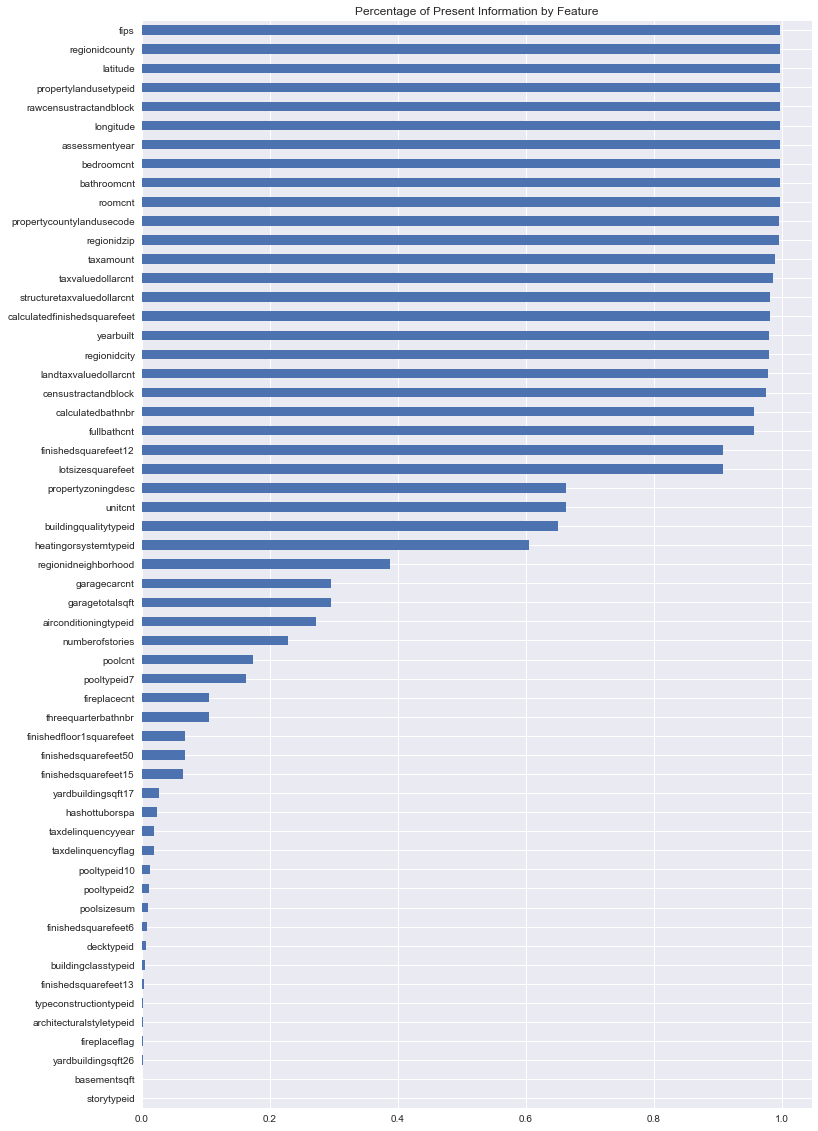

In [5]:
plt.figure(figsize=(12,20))
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.title('Percentage of Present Information by Feature')


In [6]:
property_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

fips                            0.996169
regionidcounty                  0.996169
latitude                        0.996169
propertylandusetypeid           0.996169
rawcensustractandblock          0.996169
longitude                       0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinishedsquarefeet    0.981387
yearbuilt                       0.979925
regionidcity                    0.978948
landtaxvaluedollarcnt           0.977311
censustractandblock             0.974834
calculatedbathnbr               0.956817
fullbathcnt                     0.956817
finishedsquarefeet12            0.907533
lotsizesquarefeet               0.907511
propertyzoningde

Aha, as expected "`architecturalstyletypeid`" is present in less than 1% of the homes listed. In fact, there are several features that are only present in less than 1% of homes. Intuition says that because these features are mostly absent, they are unlikely to help shed a great deal of insight. Another interesting thing of note is that there is not a single feature that is present in 100% of the homes.

Before we decide to drop some of the (mostly-missing) features, let's make sure that a cell that reads "NaN" is really symbolic of a "No". For example, if a home has a pool, "`hashottuborspa`" may have information entered, but if a home doesn't have a pool, "NaN" is entered. Knowing whether or not a home has a pool is valuable information, so let's correct that category and a few others in similar scenarios.

### Pools & Hot tubs

There are actually multiple features related to pools: 
* **"`poolcnt`"** - Number of pools on a lot. "NaN" means "0 pools", so we can update that to reflect "0" instead of "NaN".

* **"`hashottuborspa`"** - Does the home have a hottub or a spa? "NaN" means "0 hottubs or spas", so we can update that to reflect "0" instead of "NaN".

* **"`poolsizesum`"** - Total square footage of pools on property. Similarly, "NaN" means "0 sqare feet of pools", so we can also adjust that to read "0". For homes that do have pools, but are missing this information, we will just fill the "NaN" with the median value of other homes with pools.

* **"`pooltypeid2`" & "`pooltypeid7`" & "`pooltypeid10`"** - Type of pool or hottub present on property. These categories will only contain non-null information if "`poolcnt`" or "`hashottuborspa`" contain non-null information. For the pool-related categories, we can fill the "NaN" value with a "0". And because "`pooltypeid10`" tells us the exact same information as "`hashottuborspa`", we can probably drop that category from our model.

In [7]:
# "0 pools"
property_data.poolcnt.fillna(0,inplace = True)

# "0 hot tubs or spas"
property_data.hashottuborspa.fillna(0,inplace = True)

In [8]:
# Convert "True" to 1
property_data.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)

In [9]:
print property_data['hashottuborspa'].value_counts()

0    2916203
1      69014
Name: hashottuborspa, dtype: int64


In [10]:
# Set properties that have a pool but no info on poolsize equal to the median poolsize value.
property_data.loc[property_data.poolcnt==1, 'poolsizesum'] = property_data.loc[property_data.poolcnt==1, 'poolsizesum'].fillna(property_data[property_data.poolcnt==1].poolsizesum.median())

# "0 pools" = "0 sq ft of pools"
property_data.loc[property_data.poolcnt==0, 'poolsizesum']=0

# "0 pools with a spa/hot tub"
property_data.pooltypeid2.fillna(0,inplace = True)

# "0 pools without a hot tub"
property_data.pooltypeid7.fillna(0,inplace = True)

# Drop redundant feature
property_data.drop('pooltypeid10', axis=1, inplace=True)

property_data.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,0,NaN,34144442.0,-118654084.0,85768.0,0.0,0.0,0.0,0.0,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,0,NaN,34140430.0,-118625364.0,4083.0,0.0,0.0,0.0,0.0,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,0,NaN,33989359.0,-118394633.0,63085.0,0.0,0.0,0.0,0.0,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,0,NaN,34148863.0,-118437206.0,7521.0,0.0,0.0,0.0,0.0,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,0,NaN,34194168.0,-118385816.0,8512.0,0.0,0.0,0.0,0.0,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


Just like that, now all of the "pool" related categories have information.

### Fireplace Data

There are two features related to fireplaces:
* **"`fireplaceflag`"** - Does the home have a fireplace? The answers are either "True" or "NaN". We will change the "True" values to "1" and the "NaN" values to "0".
* **"`fireplacecnt`"** - How many fireplaces in the home? We can replace "NaN" values with "0".

Looking deeper, it seems odd that over 10% of the homes have 1 or more fireplaces according to the "`fireplacecnt`" feature, but less than 1% of homes actually have "`fireplaceflag`" set to "True". There are obviously some errors with this data collection. To fix this, we will do the following:
* If "`fireplaceflag`" is "True" and "`fireplacecnt`" is "NaN", we will set "`fireplacecnt`" equal to the median value of "1".
* If "`fireplacecnt`" is 1 or larger "`fireplaceflag`" is "NaN", we will set "`fireplaceflag`" to "True".
* We will change "True" in "`fireplaceflag`" to "1", so we can more easily analyze the information.

In [11]:
print property_data['fireplaceflag'].value_counts()

True    5163
Name: fireplaceflag, dtype: int64


In [12]:
# If "fireplaceflag" is "True" and "fireplacecnt" is "NaN", we will set "fireplacecnt" equal to the median value of "1".
property_data.loc[(property_data['fireplaceflag'] == True) & (property_data['fireplacecnt'].isnull()), ['fireplacecnt']] = 1

In [13]:
# If 'fireplacecnt' is "NaN", replace with "0"
property_data.fireplacecnt.fillna(0,inplace = True)

In [14]:
# If "fireplacecnt" is 1 or larger "fireplaceflag" is "NaN", we will set "fireplaceflag" to "True".
property_data.loc[(property_data['fireplacecnt'] >= 1.0) & (property_data['fireplaceflag'].isnull()), ['fireplaceflag']] = True
property_data.fireplaceflag.fillna(0,inplace = True)


In [15]:
print property_data['fireplaceflag'].value_counts()

0       2667417
True     317800
Name: fireplaceflag, dtype: int64


In [16]:
# Convert "True" to 1
property_data.fireplaceflag.replace(to_replace = True, value = 1,inplace = True)

In [17]:
print property_data['fireplaceflag'].value_counts()

0    2667417
1     317800
Name: fireplaceflag, dtype: int64


Now "`fireplacecnt`" and "`fireplaceflag`" all contain values.

### Garage Data

There are two features related to garages:
* **"`garagecarcnt`"** - How many garages does the house have? Easy fix here - we can replace "NaN" with "0" if a house doesn't have a garage.
* **"`garagetotalsqft`"** - What is the square footage of the garage? Again, if a home doesn't have a garage, we can replace "NaN" with "0".

Unlike the **Fireplace** category where we have several Type II errors (false negative), we do not have any scenarios where a home has a "`garagecarcnt`" of "NaN", but a "`garagetotalsqft`" of some value.

In [18]:
property_data.garagecarcnt.fillna(0,inplace = True)
property_data.garagetotalsqft.fillna(0,inplace = True)

### Tax Data Delinquency

There are two features related to tax delinquency:
* **"`taxdelinquencyflag`"** - Property taxes for this parcel are past due as of 2015.
* **"`taxdelinquencyyear`"** - Year for which the unpaid property taxes were due.

In [19]:
print property_data['taxdelinquencyflag'].value_counts()

Y    56462
Name: taxdelinquencyflag, dtype: int64


In [20]:
# Replace "NaN" with "0"
property_data.taxdelinquencyflag.fillna(0,inplace = True)

# Change "Y" to "1"
property_data.taxdelinquencyflag.replace(to_replace = 'Y', value = 1,inplace = True)

In [21]:
print property_data['taxdelinquencyflag'].value_counts()

0    2928755
1      56462
Name: taxdelinquencyflag, dtype: int64


In [22]:
# Drop "taxdelinquencyyear"
property_data.drop('taxdelinquencyyear', axis=1, inplace=True)

### The Rest

* **"`storytypeid`"** - Numerical ID that describes all types of homes. Mostly missing, so we should drop this category. Crazy idea would be to try and integrate street view of each home, and use image recognition to classify each type of story ID.          

In [23]:
# Drop "storytypeid"
property_data.drop('storytypeid', axis=1, inplace=True)

* **"`basementsqft`"** - Square footage of basement. Mostly missing, suggesting no basement, so we will replace "NaN" with "0".

In [24]:
# Replace "NaN" with 0, signifying no basement.
property_data.basementsqft.fillna(0,inplace = True)

* **"`yardbuildingsqft26 `"** - Storage shed square footage. We can set "NaN" values to "0". Might be useful to change this to a categorical category of just "1"s and "0"s (has a shed vs doesn't have a storage shed), but some of the sheds are enormous and others are tiny, so we will keep the actual square footage.

In [25]:
print(property_data['yardbuildingsqft26'].value_counts())

120.0     91
100.0     69
240.0     61
160.0     55
80.0      53
144.0     53
200.0     52
180.0     49
96.0      45
192.0     37
140.0     36
37.0      30
25.0      29
360.0     28
168.0     28
30.0      27
48.0      27
128.0     27
60.0      26
150.0     26
64.0      25
72.0      24
400.0     24
216.0     23
33.0      23
90.0      21
288.0     21
256.0     21
300.0     21
108.0     20
          ..
187.0      1
194.0      1
195.0      1
205.0      1
213.0      1
214.0      1
219.0      1
226.0      1
227.0      1
139.0      1
129.0      1
123.0      1
51.0       1
4000.0     1
4144.0     1
21.0       1
22.0       1
6141.0     1
34.0       1
47.0       1
59.0       1
106.0      1
61.0       1
69.0       1
73.0       1
79.0       1
83.0       1
86.0       1
89.0       1
512.0      1
Name: yardbuildingsqft26, Length: 594, dtype: int64


In [26]:
# Replace 'yardbuildingsqft26' "NaN"s with "0".
property_data.yardbuildingsqft26.fillna(0,inplace = True)

* **"`architecturalstyletypeid`"** - What is the architectural style of the house? Examples: ranch, bungalow, Cape Cod, etc. Because this is only present in a small fraction of the homes, I'm going to drop this category. (Idea: One can also assume that most homes in the same neighborhood have the same style. Could also try image recognition.)

In [27]:
# Drop "architecturalstyletypeid"
property_data.drop('architecturalstyletypeid', axis=1, inplace=True)

* **"`typeconstructiontypeid`"** - What material is the house made out of? Missing in a bunch, so probably drop category. Would be very difficult image recognition problem.

* **"`finishedsquarefeet13`"** - Perimeter of living area. This seems more like describing the shape of the house and is closely related to the square footage. I recommend dropping the category.

In [28]:
# Drop "typeconstructiontypeid" and "finishedsquarefeet13"
property_data.drop('typeconstructiontypeid', axis=1, inplace=True)
property_data.drop('finishedsquarefeet13', axis=1, inplace=True)

* **"`buildingclasstypeid`"** - Describes the internal structure of the home. Not a lot of information gained and present in less than 1% of properties. I will drop.

In [29]:
# Drop "buildingclasstypeid"
property_data.drop('buildingclasstypeid', axis=1, inplace=True)

Now let's do a quick checkup on our `property_data` to see the current shape and null-value percentages.

In [30]:
print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

(2985217, 51)


poolsizesum                     1.000000
pooltypeid7                     1.000000
basementsqft                    1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
hashottuborspa                  1.000000
poolcnt                         1.000000
taxdelinquencyflag              1.000000
pooltypeid2                     1.000000
parcelid                        1.000000
fireplaceflag                   1.000000
yardbuildingsqft26              1.000000
propertylandusetypeid           0.996169
rawcensustractandblock          0.996169
latitude                        0.996169
longitude                       0.996169
fips                            0.996169
regionidcounty                  0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip     

We are now down from 58 features to 51 features, and fewer of our features have a large percentage of null-values. Still a bit more to do!

* **"`decktypeid`"** - Type of deck (if any) on property. Looks like a value is either "66.0" or "NaN". I will keep this feature and change the "66.0" to "1" for "Yes" and "NaN" to "0" for "No".

In [31]:
# Let's check the unique values for "decktypeid"
print(property_data['decktypeid'].value_counts())

66.0    17096
Name: decktypeid, dtype: int64


In [32]:
# Change "decktypeid" "Nan"s to "0"
property_data.decktypeid.fillna(0,inplace = True)
# Convert "decktypeid" "66.0" to "1"
property_data.decktypeid.replace(to_replace = 66.0, value = 1,inplace = True)

In [33]:
print(property_data['decktypeid'].value_counts())

0.0    2968121
1.0      17096
Name: decktypeid, dtype: int64


* **"`finishedsquarefeet6`"** - Base unfinished and finished area. Not sure what this means. Seems like it gives valuable information, but replacing "NaN"s with "0"s would be incorrect. Perhaps it is a subset of other categories. Probably drop, but TBD.

* **"`finishedsquarefeet15`"** - Total area. Should be equal to sum of all other finishedsquarefeet categories.

* **"`finishedfloor1squarefeet`"** - Sq footage of first floor. Could cross check this with number of stories.

* **"`finishedsquarefeet50`"** - Identical to above category? Drop one of them. Duplicate.

* **"`finishedsquarefeet12`"** - Finished living area.

* **"`calculatedfinishedsquarefeet`"** - Total finished living area of home.

In [34]:
print(property_data['finishedsquarefeet6'].value_counts())

952.0     101
800.0      90
3820.0     88
720.0      74
600.0      68
3600.0     62
906.0      62
1750.0     61
864.0      61
4345.0     59
816.0      58
935.0      57
960.0      54
852.0      54
2820.0     50
768.0      49
1080.0     47
912.0      47
1200.0     46
480.0      46
2224.0     44
624.0      44
810.0      42
4062.0     41
780.0      41
4404.0     40
832.0      40
2530.0     39
900.0      39
4699.0     39
         ... 
3626.0      1
3625.0      1
3620.0      1
3618.0      1
3610.0      1
3690.0      1
3609.0      1
3607.0      1
1451.0      1
3606.0      1
3605.0      1
3604.0      1
3629.0      1
3630.0      1
3632.0      1
3636.0      1
3637.0      1
3646.0      1
3655.0      1
3658.0      1
3664.0      1
3665.0      1
3670.0      1
3671.0      1
3674.0      1
3675.0      1
3676.0      1
3683.0      1
1414.0      1
2722.0      1
Name: finishedsquarefeet6, Length: 4251, dtype: int64


In [35]:
#squarefeet = property_data[property_data['finishedsquarefeet6'].notnull() & property_data['finishedsquarefeet12'].isnull() & property_data['finishedsquarefeet15'].isnull() & property_data['finishedsquarefeet50'].isnull() & property_data['lotsizesquarefeet'].isnull()]
#squarefeet = property_data[property_data['finishedsquarefeet12'].notnull() & property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
squarefeet = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
squarefeet[['calculatedfinishedsquarefeet','finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','numberofstories','lotsizesquarefeet','landtaxvaluedollarcnt','structuretaxvaluedollarcnt','taxvaluedollarcnt','taxamount']]
#squarefeet
# squarefeet = property_data[property_data[['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','lotsizesquarefeet']].notnull()]
#property_data[['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet15','finishedsquarefeet50','lotsizesquarefeet']][:100]


,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet15,finishedsquarefeet50,numberofstories,lotsizesquarefeet,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
354,816.0,NaN,NaN,816.0,816.0,1.0,5334.0,182893.0,78382.0,261275.0,2850.52
474,1558.0,NaN,NaN,1558.0,1558.0,1.0,7594.0,175889.0,98124.0,274013.0,3044.24
543,632.0,NaN,NaN,632.0,632.0,1.0,41759.0,23036.0,512223.0,535259.0,6818.70
759,779.0,NaN,NaN,779.0,779.0,1.0,5700.0,22599.0,67865.0,90464.0,1102.38
29968,1059.0,NaN,NaN,1059.0,1059.0,1.0,6250.0,87090.0,103484.0,190574.0,2146.46
30026,704.0,NaN,NaN,704.0,704.0,1.0,6250.0,162983.0,75218.0,238201.0,2753.52
30072,1280.0,NaN,NaN,1280.0,1280.0,1.0,8500.0,312273.0,376604.0,688877.0,7340.46
30089,1120.0,NaN,NaN,1120.0,1120.0,1.0,8051.0,169567.0,275401.0,444968.0,4706.64
30418,1208.0,NaN,NaN,1208.0,1043.0,1.0,7257.0,179552.0,162373.0,341925.0,4207.70
30745,908.0,NaN,NaN,908.0,908.0,1.0,41382.0,179305.0,71721.0,251026.0,2784.92


**"`finishedsquarefeet6`"** is rarely present, and even when it is present, it is equal to **"`calculatedfinishedsquarefeet`"**. Because of this, we will drop it. Same scenario with **"`finishedsquarefeet12`"**, so we will drop that as well. **"`finishedsquarefeet50`"** is identical to **"`finishedfloor1squarefeet`"**, so we will also drop **"`finishedfloor1squarefeet`"**.

In [36]:
# Drop "finishedsquarefeet6"
property_data.drop('finishedsquarefeet6', axis=1, inplace=True)

# Drop "finishedsquarefeet12"
property_data.drop('finishedsquarefeet12', axis=1, inplace=True)

# Drop "finishedfloor1squarefeet"
property_data.drop('finishedfloor1squarefeet', axis=1, inplace=True)

* ~~**"`finishedsquarefeet6`"** - Base unfinished and finished area.~~ DROPPED

* **"`finishedsquarefeet15`"** - Total area. Should be equal to sum of all other finishedsquarefeet categories.

* ~~**"`finishedfloor1squarefeet`"** - Sq footage of first floor.~~ DROPPED

* **"`finishedsquarefeet50`"** - Sq footage of first floor.

* ~~**"`finishedsquarefeet12`"** - Finished living area.~~ DROPPED

* **"`calculatedfinishedsquarefeet`"** - Total finished living area of home.

In [37]:
squarefeet2 = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['finishedsquarefeet50'].notnull() & property_data['lotsizesquarefeet'].notnull()]
#squarefeet2 = property_data[property_data['finishedsquarefeet15'].notnull() & property_data['calculatedfinishedsquarefeet'].isnull()]
squarefeet2[['calculatedfinishedsquarefeet','finishedsquarefeet15','finishedsquarefeet50','numberofstories','lotsizesquarefeet']]


,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,numberofstories,lotsizesquarefeet
354,816.0,816.0,816.0,1.0,5334.0
474,1558.0,1558.0,1558.0,1.0,7594.0
543,632.0,632.0,632.0,1.0,41759.0
759,779.0,779.0,779.0,1.0,5700.0
29968,1059.0,1059.0,1059.0,1.0,6250.0
30026,704.0,704.0,704.0,1.0,6250.0
30072,1280.0,1280.0,1280.0,1.0,8500.0
30089,1120.0,1120.0,1120.0,1.0,8051.0
30418,1208.0,1208.0,1043.0,1.0,7257.0
30745,908.0,908.0,908.0,1.0,41382.0


In [38]:
property_data.notnull().mean().sort_values(ascending = False)

pooltypeid2                     1.000000
pooltypeid7                     1.000000
basementsqft                    1.000000
decktypeid                      1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
hashottuborspa                  1.000000
poolcnt                         1.000000
poolsizesum                     1.000000
taxdelinquencyflag              1.000000
parcelid                        1.000000
fireplaceflag                   1.000000
yardbuildingsqft26              1.000000
latitude                        0.996169
longitude                       0.996169
regionidcounty                  0.996169
rawcensustractandblock          0.996169
fips                            0.996169
propertylandusetypeid           0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountyla

Of the six "squarefeet" categories listed above, we dropped three and are left with these three:

* **"`calculatedfinishedsquarefeet`"** - Present in 98%. Total finished living area of home. Let's fill the rest with the median values.

* **"`finishedsquarefeet15`"** - Present in 6.4%. Most cases, it is equal to **"`calculatedfinishedsquarefeet`"**, so we will fill in the "NaN" values with the value of **"`calculatedfinishedsquarefeet`"**. Total area. Should be equal to sum of all other finishedsquarefeet categories.

* **"`finishedsquarefeet50`"** - If **"`numberofstories`"** is equal to "1", then we can replace the "NaN"s with the **"`calculatedfinishedsquarefeet`"** value. Fill in the rest with the average values.

In [39]:
# Replace "NaN" "calculatedfinishedsquarefeet" values with mean.
property_data['calculatedfinishedsquarefeet'].fillna((property_data['calculatedfinishedsquarefeet'].mean()), inplace=True)

In [40]:
# Replace "NaN" "finishedsquarefeet15" values with calculatedfinishedsquarefeet.
property_data.loc[property_data['finishedsquarefeet15'].isnull(),'finishedsquarefeet15'] = property_data['calculatedfinishedsquarefeet']
#property_data['finishedsquarefeet15'].fillna(property_data['calculatedfinishedsquarefeet'])


In [41]:
property_data.numberofstories.fillna(1,inplace = True)

In [42]:
property_data.notnull().mean().sort_values(ascending = False)

pooltypeid2                     1.000000
pooltypeid7                     1.000000
basementsqft                    1.000000
decktypeid                      1.000000
calculatedfinishedsquarefeet    1.000000
finishedsquarefeet15            1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
hashottuborspa                  1.000000
poolcnt                         1.000000
poolsizesum                     1.000000
taxdelinquencyflag              1.000000
parcelid                        1.000000
yardbuildingsqft26              1.000000
fireplaceflag                   1.000000
numberofstories                 1.000000
regionidcounty                  0.996169
rawcensustractandblock          0.996169
propertylandusetypeid           0.996169
latitude                        0.996169
longitude                       0.996169
fips                            0.996169
assessmentyear                  0.996168
bedroomcnt      

In [43]:
print(property_data['numberofstories'].value_counts())

1.0     2727334
2.0      242125
3.0       15678
4.0          58
5.0          11
6.0           4
7.0           2
41.0          1
20.0          1
17.0          1
14.0          1
8.0           1
Name: numberofstories, dtype: int64


In [44]:
# If "numberofstories" is equal to "1", then we can replace the "NaN"s with the "calculatedfinishedsquarefeet" value. Fill in the rest with the average values.
property_data.loc[property_data['numberofstories'] == 1.0,'finishedsquarefeet50'] = property_data['calculatedfinishedsquarefeet']
property_data['finishedsquarefeet50'].fillna((property_data['finishedsquarefeet50'].mean()), inplace=True)


In [45]:
print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

(2985217, 48)


pooltypeid2                     1.000000
pooltypeid7                     1.000000
basementsqft                    1.000000
decktypeid                      1.000000
calculatedfinishedsquarefeet    1.000000
finishedsquarefeet15            1.000000
finishedsquarefeet50            1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
hashottuborspa                  1.000000
poolcnt                         1.000000
poolsizesum                     1.000000
taxdelinquencyflag              1.000000
parcelid                        1.000000
yardbuildingsqft26              1.000000
fireplaceflag                   1.000000
numberofstories                 1.000000
latitude                        0.996169
regionidcounty                  0.996169
rawcensustractandblock          0.996169
propertylandusetypeid           0.996169
fips                            0.996169
longitude                       0.996169
assessmentyear  

* **"`yardbuildingsqft17`"** - Patio in yard. Do same as storage shed category.

In [46]:
# Replace 'yardbuildingsqft17' "NaN"s with "0".
property_data.yardbuildingsqft17.fillna(0,inplace = True)

Now let's dig into the bathroom features.
* **"`threequarterbathnbr`"** - Number of 3/4 baths = shower, sink, toilet.

* **"`fullbathcnt`"** - Number of full bathrooms - tub, sink, toilet

* **"`calculatedbathnbr`"** - Total number of bathrooms including partials.

It seems like **"`calculatedbathnbr`"** should encompass the other two, so I will probably drop **"`threequarterbathnbr`"** and **"`fullbathcnt`"**, but let's take a look at some data first...

In [47]:
bathrooms = property_data[property_data['fullbathcnt'].notnull() & property_data['threequarterbathnbr'].notnull() & property_data['calculatedbathnbr'].notnull()]
bathrooms[['fullbathcnt','threequarterbathnbr','calculatedbathnbr']]


,fullbathcnt,threequarterbathnbr,calculatedbathnbr
245,2.0,1.0,2.5
246,3.0,1.0,3.5
247,2.0,1.0,2.5
262,3.0,1.0,3.5
264,2.0,1.0,2.5
266,2.0,1.0,2.5
272,2.0,1.0,2.5
303,2.0,1.0,2.5
304,2.0,1.0,2.5
306,3.0,1.0,3.5


It looks like **"`threequarterbathnbr`"** is only a half-bath. Because **"`calculatedbathnbr`"** incorporates the other two, we will drop them. Then we will fill in the missing values for **"`calculatedbathnbr`"** with the most common answer.

In [48]:
# Drop "threequarterbathnbr"
property_data.drop('threequarterbathnbr', axis=1, inplace=True)

# Drop "fullbathcnt"
property_data.drop('fullbathcnt', axis=1, inplace=True)

# Fill in "NaN" "calculatedbathnbr" with most common
bathroommode = property_data['calculatedbathnbr'].value_counts().argmax()
property_data['calculatedbathnbr'] = property_data['calculatedbathnbr'].fillna(bathroommode)

In [49]:
print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

(2985217, 46)


pooltypeid2                     1.000000
pooltypeid7                     1.000000
basementsqft                    1.000000
calculatedbathnbr               1.000000
decktypeid                      1.000000
calculatedfinishedsquarefeet    1.000000
finishedsquarefeet15            1.000000
finishedsquarefeet50            1.000000
fireplacecnt                    1.000000
garagecarcnt                    1.000000
garagetotalsqft                 1.000000
hashottuborspa                  1.000000
poolcnt                         1.000000
poolsizesum                     1.000000
taxdelinquencyflag              1.000000
parcelid                        1.000000
yardbuildingsqft26              1.000000
fireplaceflag                   1.000000
numberofstories                 1.000000
yardbuildingsqft17              1.000000
longitude                       0.996169
fips                            0.996169
latitude                        0.996169
regionidcounty                  0.996169
rawcensustractan

* **"`airconditioningtypeid`"** - If "NaN", change to "5" for "None".

In [50]:
property_data.airconditioningtypeid.fillna(5,inplace = True)

* **"`regionidneighborhood`"** - Neighborhood. Could fill in blanks. Would need a key that maps lat & longitude regions with specific neighborhoods. Because **"`longitude`"** and **"`latitude`"** essentially provide this information, we will drop **"`regionidneighborhood`"**.

In [51]:
# Drop "regionidneighborhood"
property_data.drop('regionidneighborhood', axis=1, inplace=True)

* **"`heatingorsystemtypeid`"** - Change "NaN" to "13" for "None"

In [52]:
property_data.heatingorsystemtypeid.fillna(13,inplace = True)

* **"`buildingqualitytypeid`"** - Change "NaN" to most common value.

In [53]:
print(property_data['buildingqualitytypeid'].value_counts())

7.0     1133238
4.0      692160
1.0       69467
10.0      39713
12.0       3692
6.0          94
8.0          51
9.0          25
5.0          21
11.0         19
3.0           6
2.0           2
Name: buildingqualitytypeid, dtype: int64


In [54]:
# Fill in "NaN" "buildingqualitytypeid" with most common
buildingqual = property_data['buildingqualitytypeid'].value_counts().argmax()
property_data['buildingqualitytypeid'] = property_data['buildingqualitytypeid'].fillna(buildingqual)

* **"`unitcnt`"** - Number of units in a property. Change "NaN" to "1"

In [55]:
property_data.unitcnt.fillna(1,inplace = True)

* **"`propertyzoningdesc`"** - This seems like a very error-ridden column with so many unique values. It may provide some valuable info, so lets just fill the "NaN" with the most common value.

In [56]:
print(property_data['propertyzoningdesc'].value_counts())

LAR1          275029
LAR3           67105
LARS           54859
LBR1N          52750
LAR2           48808
LARD1.5        39895
SCUR2          30459
LARD2          30377
TORR-LO        26632
LARA           26103
LARE11         24005
LCR1YY         22460
LARE15         18655
CARS*          17021
PSR6           15032
LCR1*          14916
LKR1YY         13470
LAR4           12750
LARD3          12424
GLR1YY         12252
LAC2           11917
PRSF*          11483
LCA11*         10633
BUR1YY         10472
LCA106         10340
SCUR3          10126
BPR1*          10080
CERS5000       10075
NOR1YY          9874
ALRPD*          9324
               ...  
TCR175*            1
SRR11OOO*          1
SDRDD10*           1
PSR3*              1
BPR3-R1*           1
RBMU-1/R-3         1
LCU 1              1
D0R15000*          1
LCA12              1
PSR2YY             1
LCRPD12.25         1
1DC*               1
AHRS               1
DOP2*              1
INMI               1
SFR11Y             1
SDR17500     

In [57]:
# Fill in "NaN" "propertyzoningdesc" with most common
propertyzoningdesc = property_data['propertyzoningdesc'].value_counts().argmax()
property_data['propertyzoningdesc'] = property_data['propertyzoningdesc'].fillna(propertyzoningdesc)

* **"`lotsizesquarefeet`"** - Area of lot in square feet. Fill "NaN" with average.

In [58]:
property_data['lotsizesquarefeet'].fillna((property_data['lotsizesquarefeet'].mean()), inplace=True)

* **"`censustractandblock`"** & **"`rawcensustractandblock`"** - Census tract and block ID combined. Look like duplicate values. I think we should drop these because they are related to location which is covered by **"`longitude`"** and **"`latitude`"**. Let's view the values first.

In [59]:
print(property_data['censustractandblock'].value_counts())
print(property_data['rawcensustractandblock'].value_counts())

6.037920e+13    1171
6.037137e+13     881
6.037920e+13     811
6.059063e+13     807
6.059052e+13     806
6.037277e+13     800
6.037920e+13     779
6.111007e+13     765
6.037577e+13     753
6.059052e+13     723
6.037208e+13     718
6.059053e+13     684
6.037142e+13     650
6.111008e+13     631
6.037275e+13     630
6.037236e+13     628
6.059052e+13     614
6.059063e+13     613
6.059074e+13     609
6.037262e+13     608
6.037261e+13     599
6.037296e+13     596
6.059075e+13     593
6.037113e+13     590
6.037140e+13     586
6.059074e+13     584
6.059042e+13     582
6.059032e+13     580
6.037578e+13     569
6.059032e+13     568
                ... 
6.037535e+13       1
6.059032e+13       1
6.037261e+13       1
6.037571e+13       1
6.037574e+13       1
6.037209e+13       1
6.037200e+13       1
6.111008e+13       1
6.037702e+13       1
6.037531e+13       1
6.037901e+13       1
6.037911e+13       1
6.037900e+13       1
6.059053e+13       1
6.037462e+13       1
6.037901e+13       1
6.037901e+13 

These look like information we might be able to work with. Let's just drop **"`censustractandblock`"** because it is the same as **"`rawcensustractandblock`"**.

In [60]:
# Drop "censustractandblock"
property_data.drop('censustractandblock', axis=1, inplace=True)

* **"`landtaxvaluedollarcnt`"** - Assessed value of land area of parcel.

* **"`structuretaxvaluedollarcnt`"** - Assessed value of built structure on land.

* **"`taxvaluedollarcnt`"** - Total tax assessed value of property. "structuretax..." + "landtax...".

* **"`taxamount`"** - Total property tax assessed for assessment year.

Let's filter our data and view the relationships of these columns. This should allow us to strategically fill in the blanks.

In [61]:
#taxdata = property_data[property_data['taxvaluedollarcnt'].isnull()]
taxdata = property_data[property_data['landtaxvaluedollarcnt'].notnull() & property_data['structuretaxvaluedollarcnt'].notnull() & property_data['taxvaluedollarcnt'].notnull() & property_data['taxamount'].notnull()]
taxdata[['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','taxvaluedollarcnt','taxamount']]

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount
2,762631.0,650756.0,1413387.0,20800.37
3,585488.0,571346.0,1156834.0,14557.57
4,239695.0,193796.0,433491.0,5725.17
5,106932.0,176383.0,283315.0,3661.28
6,156628.0,397945.0,554573.0,6773.34
7,586488.0,101998.0,688486.0,7857.84
9,42761.0,218440.0,261201.0,4054.76
10,184374.0,245834.0,430208.0,6014.18
17,29770.0,32654.0,62424.0,2330.24
18,45649.0,56736.0,102385.0,4162.56


* **"`landtaxvaluedollarcnt`"** - We can fill in the "NaN"s with "0". It appears some properties do not have own any land. An example of this could be an apartment in large building where only the structurevalue would exist.

* **"`structuretaxvaluedollarcnt`"** - Same as **"`landtaxvaluedollarcnt`"**, but opposite. An example of a "NaN" in this category would be an empty lot.

* **"`taxvaluedollarcnt`"** - We can just fill in the "NaN" values with the average.

* **"`taxamount`"** - We should calculate a new category called 'taxpercentage' where we divide the taxamount by the 'taxvaluedollarcnt', then we can fill in the "NaN" values with the average tax percentage.

In [62]:
property_data.landtaxvaluedollarcnt.fillna(0,inplace = True)

property_data.structuretaxvaluedollarcnt.fillna(0,inplace = True)

property_data['taxvaluedollarcnt'].fillna((property_data['taxvaluedollarcnt'].mean()), inplace=True)

In [63]:
property_data['taxpercentage'] = property_data['taxamount'] / property_data['taxvaluedollarcnt']
property_data.head()

,parcelid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxpercentage
0,10754147,5.0,0.0,0.0,0.0,7.0,2.0,0.0,1827.162124,1827.162124,1827.162124,6037.0,0.0,0.0,0.0,0,13.0,34144442.0,-118654084.0,85768.0,0.0,0.0,0.0,0.0,010D,269.0,LAR1,6.037800e+07,37688.0,3101.0,96337.0,0.0,1.0,0.0,0.0,NaN,1.0,0,0.0,9.0,2015.0,9.0,NaN,0,NaN
1,10759547,5.0,0.0,0.0,0.0,7.0,2.0,0.0,1827.162124,1827.162124,1827.162124,6037.0,0.0,0.0,0.0,0,13.0,34140430.0,-118625364.0,4083.0,0.0,0.0,0.0,0.0,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,96337.0,0.0,1.0,0.0,0.0,NaN,1.0,0,0.0,27516.0,2015.0,27516.0,NaN,0,NaN
2,10843547,5.0,0.0,0.0,0.0,7.0,2.0,0.0,73026.000000,73026.000000,73026.000000,6037.0,0.0,0.0,0.0,0,13.0,33989359.0,-118394633.0,63085.0,0.0,0.0,0.0,0.0,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,96095.0,0.0,2.0,0.0,0.0,NaN,1.0,0,650756.0,1413387.0,2015.0,762631.0,20800.37,0,0.014717
3,10859147,5.0,0.0,0.0,0.0,7.0,2.0,0.0,5068.000000,5068.000000,5068.000000,6037.0,0.0,0.0,0.0,0,13.0,34148863.0,-118437206.0,7521.0,0.0,0.0,0.0,0.0,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,96424.0,0.0,1.0,0.0,0.0,1948.0,1.0,0,571346.0,1156834.0,2015.0,585488.0,14557.57,0,0.012584
4,10879947,5.0,0.0,0.0,0.0,7.0,2.0,0.0,1776.000000,1776.000000,1776.000000,6037.0,0.0,0.0,0.0,0,13.0,34194168.0,-118385816.0,8512.0,0.0,0.0,0.0,0.0,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,96450.0,0.0,1.0,0.0,0.0,1947.0,1.0,0,193796.0,433491.0,2015.0,239695.0,5725.17,0,0.013207


In [64]:
property_data['taxpercentage'].fillna((property_data['taxpercentage'].mean()), inplace=True)


Now we will drop **"`taxamount`"** because we have replaced it with **"`taxpercentage`"**.

In [65]:
# Drop "taxamount"
property_data.drop('taxamount', axis=1, inplace=True)

* **"`regionidcity`"** - City property is located in. This is redundant information, so we will drop.

In [66]:
# Drop "regionidcity"
property_data.drop('regionidcity', axis=1, inplace=True)

* **"`yearbuilt`"** - Year home was built. We can just fill in the "NaN" values with the most common value.

In [67]:
# Fill in "NaN" "yearbuilt" with most common
yearbuilt = property_data['yearbuilt'].value_counts().argmax()
property_data['yearbuilt'] = property_data['yearbuilt'].fillna(yearbuilt)

In [68]:
print property_data.shape
print property_data.dtypes
property_data.notnull().mean().sort_values(ascending = False)

(2985217, 43)
parcelid                          int64
airconditioningtypeid           float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
fips                            float64
fireplacecnt                    float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                    int64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
poolsizesum                     float64
pooltypeid2                     float64
pooltypeid7                     float64
propertycountylandusecode 

taxpercentage                   1.000000
fireplacecnt                    1.000000
taxdelinquencyflag              1.000000
poolcnt                         1.000000
lotsizesquarefeet               1.000000
heatingorsystemtypeid           1.000000
hashottuborspa                  1.000000
garagetotalsqft                 1.000000
garagecarcnt                    1.000000
finishedsquarefeet50            1.000000
pooltypeid7                     1.000000
finishedsquarefeet15            1.000000
calculatedfinishedsquarefeet    1.000000
decktypeid                      1.000000
calculatedbathnbr               1.000000
buildingqualitytypeid           1.000000
basementsqft                    1.000000
airconditioningtypeid           1.000000
pooltypeid2                     1.000000
poolsizesum                     1.000000
parcelid                        1.000000
yardbuildingsqft26              1.000000
propertyzoningdesc              1.000000
landtaxvaluedollarcnt           1.000000
taxvaluedollarcn

In [69]:
# Fill in "fips" "NaN"s
fips = property_data['fips'].value_counts().argmax()
property_data['fips'] = property_data['fips'].fillna(fips)

# Fill in "propertylandusetypeid" "NaN"s
propertylandusetypeid = property_data['propertylandusetypeid'].value_counts().argmax()
property_data['propertylandusetypeid'] = property_data['propertylandusetypeid'].fillna(propertylandusetypeid)

# Drop 'regionidcounty'
property_data.drop('regionidcounty', axis=1, inplace=True)

# Fill in "latitude" "NaN"s
latitude = property_data['latitude'].value_counts().argmax()
property_data['latitude'] = property_data['latitude'].fillna(latitude)

# Fill in "longitude" "NaN"s
longitude = property_data['longitude'].value_counts().argmax()
property_data['longitude'] = property_data['longitude'].fillna(longitude)

# Fill in "rawcensustractandblock" "NaN"s
rawcensustractandblock = property_data['rawcensustractandblock'].value_counts().argmax()
property_data['rawcensustractandblock'] = property_data['rawcensustractandblock'].fillna(rawcensustractandblock)

# Fill in "assessmentyear" "NaN"s
assessmentyear = property_data['assessmentyear'].value_counts().argmax()
property_data['assessmentyear'] = property_data['assessmentyear'].fillna(assessmentyear)

# Fill in "bedroomcnt" "NaN"s
bedroomcnt = property_data['bedroomcnt'].value_counts().argmax()
property_data['bedroomcnt'] = property_data['bedroomcnt'].fillna(bedroomcnt)

# Fill in "bathroomcnt" "NaN"s
bathroomcnt = property_data['bathroomcnt'].value_counts().argmax()
property_data['bathroomcnt'] = property_data['bathroomcnt'].fillna(bathroomcnt)

# Fill in "roomcnt" "NaN"s
roomcnt = property_data['roomcnt'].value_counts().argmax()
property_data['roomcnt'] = property_data['roomcnt'].fillna(roomcnt)

# Fill in "propertycountylandusecode" "NaN"s
propertycountylandusecode = property_data['propertycountylandusecode'].value_counts().argmax()
property_data['propertycountylandusecode'] = property_data['propertycountylandusecode'].fillna(propertycountylandusecode)

# Fill in "regionidzip " "NaN"s
regionidzip = property_data['regionidzip'].value_counts().argmax()
property_data['regionidzip'] = property_data['regionidzip'].fillna(regionidzip)

In [70]:
print property_data.shape
property_data.notnull().mean().sort_values(ascending = False)

(2985217, 42)


taxpercentage                   1.0
finishedsquarefeet50            1.0
longitude                       1.0
latitude                        1.0
heatingorsystemtypeid           1.0
hashottuborspa                  1.0
garagetotalsqft                 1.0
garagecarcnt                    1.0
fireplacecnt                    1.0
fips                            1.0
finishedsquarefeet15            1.0
taxdelinquencyflag              1.0
calculatedfinishedsquarefeet    1.0
decktypeid                      1.0
calculatedbathnbr               1.0
buildingqualitytypeid           1.0
bedroomcnt                      1.0
bathroomcnt                     1.0
basementsqft                    1.0
airconditioningtypeid           1.0
lotsizesquarefeet               1.0
poolcnt                         1.0
poolsizesum                     1.0
pooltypeid2                     1.0
landtaxvaluedollarcnt           1.0
assessmentyear                  1.0
taxvaluedollarcnt               1.0
structuretaxvaluedollarcnt  

Okay, so we have reduced our messy, sparce dataset from 58 columns down to 42 completely full columns. Next, we will graph some simple statistics.

Tomorrow -
Graph simple statistics.<br>
Create a few new categories.<br>
Apply Month, Day, Year.<br>
Create Tax Features.<br>
Merge with transaction data.<br>
Generage geographical maps. <br>
Year built vs. log error. <br>
Correlation Coefficients.<br>
Build Train & Testing Data. <br>



### Log Error

Now let's go back to the training data and clean that up a bit. First, let's break up the date into three columns: month, day, year

In [71]:
train_with_months = train_data


In [72]:
train_with_months['sale_month'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).month)
train_with_months['sale_day'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).day)
train_with_months['sale_year'] = train_with_months['transactiondate'].apply(lambda x: (x.to_pydatetime()).year)

In [73]:
train_with_months.head(10)

,parcelid,logerror,transactiondate,sale_month,sale_day,sale_year
0,11016594,0.0276,2016-01-01,1,1,2016
1,14366692,-0.1684,2016-01-01,1,1,2016
2,12098116,-0.0040,2016-01-01,1,1,2016
3,12643413,0.0218,2016-01-02,1,2,2016
4,14432541,-0.0050,2016-01-02,1,2,2016
5,11509835,-0.2705,2016-01-02,1,2,2016
6,12286022,0.0440,2016-01-02,1,2,2016
7,17177301,0.1638,2016-01-02,1,2,2016
8,14739064,-0.0030,2016-01-02,1,2,2016
9,14677559,0.0843,2016-01-03,1,3,2016


Now let's graph the sales over time.

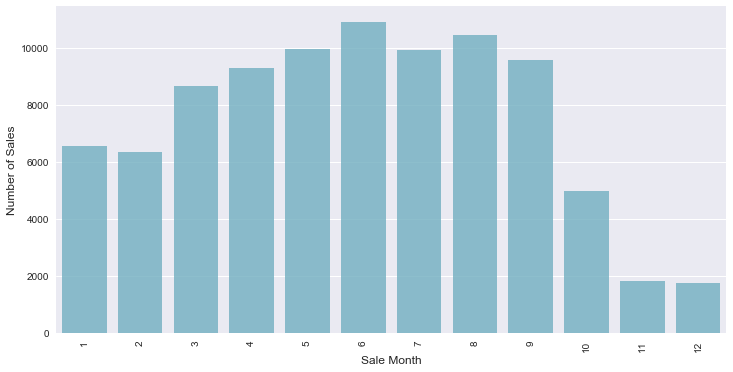

In [74]:
color = sns.color_palette()

num_of_sales = train_with_months['sale_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(num_of_sales.index, num_of_sales.values, alpha=0.8, color=color[5])
plt.xticks(rotation='vertical')
plt.xlabel('Sale Month', fontsize=12)
plt.ylabel('Number of Sales', fontsize=12)
plt.show()

Here we can see that home sales are relatively seasonal. Most sales occur between March and September, with a considerable dropoff between October and February.

Now I'm curious to see what the average log error is month by month.

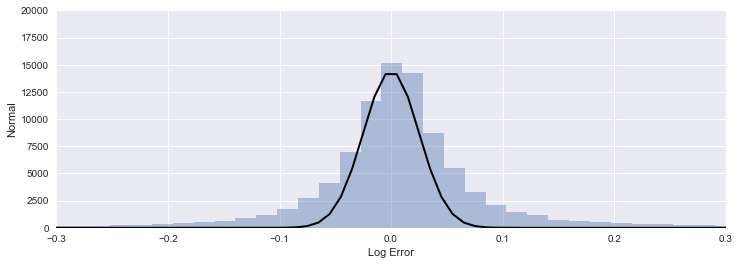

In [75]:
from scipy.stats import norm
plt.figure(figsize=(12,4))
sns.distplot(train_with_months.logerror.values, bins=500, kde=False)
plt.xlabel('Log Error')
mu, std = norm.fit(train_with_months.logerror.values)
xmin,xmax=plt.xlim()
x = np.linspace(-5,5,1000)
p = norm.pdf(x, 0, 0.025)
plt.plot(x, p*(x[1]-x[0])*90275, 'k', linewidth=2)
plt.axis([-0.3,0.3,0,20000])
plt.ylabel('Normal')

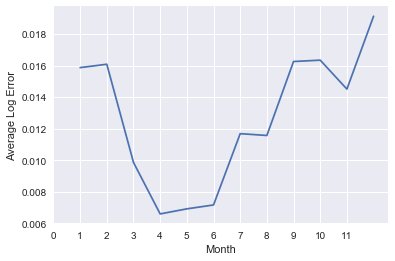

In [76]:
avg_logs_table = []
for x in range(1,13):
    avg_logs = np.mean(train_with_months[train_with_months['sale_month'] == x]['logerror'])
    avg_logs_table.append(avg_logs)

t = range(1,13)
plt.plot(t,avg_logs_table)
plt.xticks(np.linspace(0,11,12,endpoint=True))
plt.xlabel('Month')
plt.ylabel('Average Log Error')

I realized that we took the mean, but our logerrors were both positive (property is overpriced) and negative (property was underestimated) values. Seeing how the average log error for each month is a positive value, however, we can conclude that Zillow's Zestimate tends to overvalue home prices.

Let's try making a graph with the absolute value of the log errors.

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


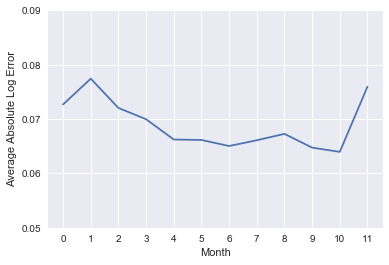

In [77]:
abs_log_error_list = train_with_months[['logerror','sale_month']]
abs_log_error_list['logerror'] = np.abs(abs_log_error_list['logerror'])

avg_abs_logs_table = []
for i in range(1,13):
    avg_logs = np.mean(abs_log_error_list[abs_log_error_list['sale_month'] == i]['logerror'])
    avg_abs_logs_table.append(avg_logs)

plt.plot(avg_abs_logs_table)
plt.xticks(np.linspace(0,11,12,endpoint=True))
plt.yticks(np.linspace(0.05,0.09,5,endpoint=True))
plt.xlabel('Month')
plt.ylabel('Average Absolute Log Error')

The average absolute log errors are highest in December, January, February and March. These are also months where fewer houses are sold. Speculating, one might hypothesize that selling prices during these months might be a bit more sparatic than other months. If a seller is trying to sell a home in December, when demand is lower than other months, the seller may be willing to accept an offer below market rather than hold onto the home for a few more months.

### Create New Features

In [78]:
property_data['taxpersqft'] = property_data['taxvaluedollarcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['bathpersqft'] = property_data['bathroomcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['roompersqft'] = property_data['roomcnt'] / property_data['calculatedfinishedsquarefeet']
property_data['bedroompersqft'] = property_data['bedroomcnt'] / property_data['calculatedfinishedsquarefeet']

### Merge the Datasets

In [79]:
#train_data.drop(['sale_year','sale_day'],axis=1,inplace=True)
merged_data = train_data.merge(property_data,on='parcelid',how='left')
merged_data.head(5)

,parcelid,logerror,transactiondate,sale_month,sale_day,sale_year,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidzip,roomcnt,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxdelinquencyflag,taxpercentage,taxpersqft,bathpersqft,roompersqft,bedroompersqft
0,11016594,0.0276,2016-01-01,1,1,2016,1.0,0.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,1684.000000,6037.0,0.0,0.0,0.0,0,2.0,34280990.0,-118488536.0,7528.0,0.0,0.0,0.0,0.0,0100,261.0,LARS,6.037107e+07,96370.0,0.0,1.0,0.0,0.0,1959.0,1.0,0,122754.0,360170.0,2015.0,237416.0,0,0.018702,213.877672,0.001188,0.000000,0.001781
1,14366692,-0.1684,2016-01-01,1,1,2016,5.0,0.0,3.5,4.0,7.0,3.5,0.0,2263.0,2263.0,2263.000000,6059.0,0.0,2.0,468.0,0,13.0,33668120.0,-117677556.0,3643.0,0.0,0.0,0.0,0.0,1,261.0,LAR1,6.059052e+07,96962.0,0.0,1.0,0.0,0.0,2014.0,1.0,0,346458.0,585529.0,2015.0,239071.0,0,0.017340,258.740168,0.001547,0.000000,0.001768
2,12098116,-0.0040,2016-01-01,1,1,2016,1.0,0.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,2217.000000,6037.0,0.0,0.0,0.0,0,2.0,34136312.0,-118175032.0,11423.0,0.0,0.0,0.0,0.0,0100,261.0,PSR6,6.037464e+07,96293.0,0.0,1.0,0.0,0.0,1940.0,1.0,0,61994.0,119906.0,2015.0,57912.0,0,0.095779,54.084799,0.001353,0.000000,0.000902
3,12643413,0.0218,2016-01-02,1,2,2016,1.0,0.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,839.000000,6037.0,0.0,0.0,0.0,0,2.0,33755800.0,-118309000.0,70859.0,0.0,0.0,0.0,0.0,010C,266.0,LAR3,6.037296e+07,96222.0,0.0,1.0,0.0,0.0,1987.0,1.0,0,171518.0,244880.0,2015.0,73362.0,0,0.012450,291.871275,0.002384,0.000000,0.002384
4,14432541,-0.0050,2016-01-02,1,2,2016,5.0,0.0,2.5,4.0,7.0,2.5,0.0,2283.0,2283.0,1767.299285,6059.0,0.0,2.0,598.0,0,13.0,33485643.0,-117700234.0,6000.0,1.0,495.0,0.0,1.0,122,261.0,LAR1,6.059042e+07,96961.0,8.0,1.0,0.0,0.0,1981.0,2.0,0,169574.0,434551.0,2015.0,264977.0,0,0.012631,190.342094,0.001095,0.003504,0.001752


In [80]:
train_data.drop(['sale_month','sale_year','sale_day'],axis=1,inplace=True)

### Draw Geographical Maps

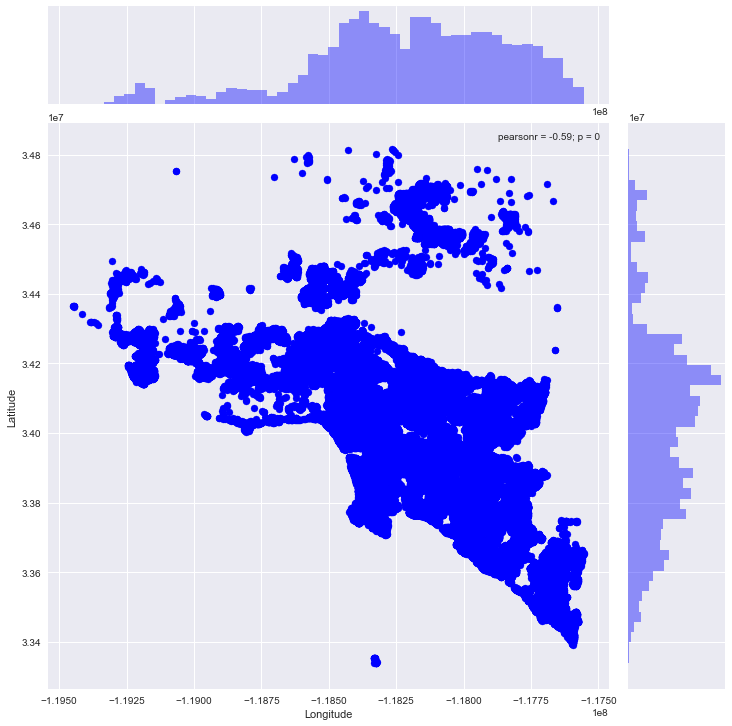

In [81]:
# exploratory analysis
# location distribution
plt.figure(figsize=(12,12))
fig=sns.jointplot(x=merged_data.longitude.values, y=merged_data.latitude.values, size=10,color='b')
fig.set_axis_labels('Longitude','Latitude')
#plt.colorbar(orientation="vertical",fraction=0.07)
plt.show()

### Univariate Analysis

Because there are so many variables, let's see if there is a correlation between some of the float variables and the 'logerror' target variable.

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


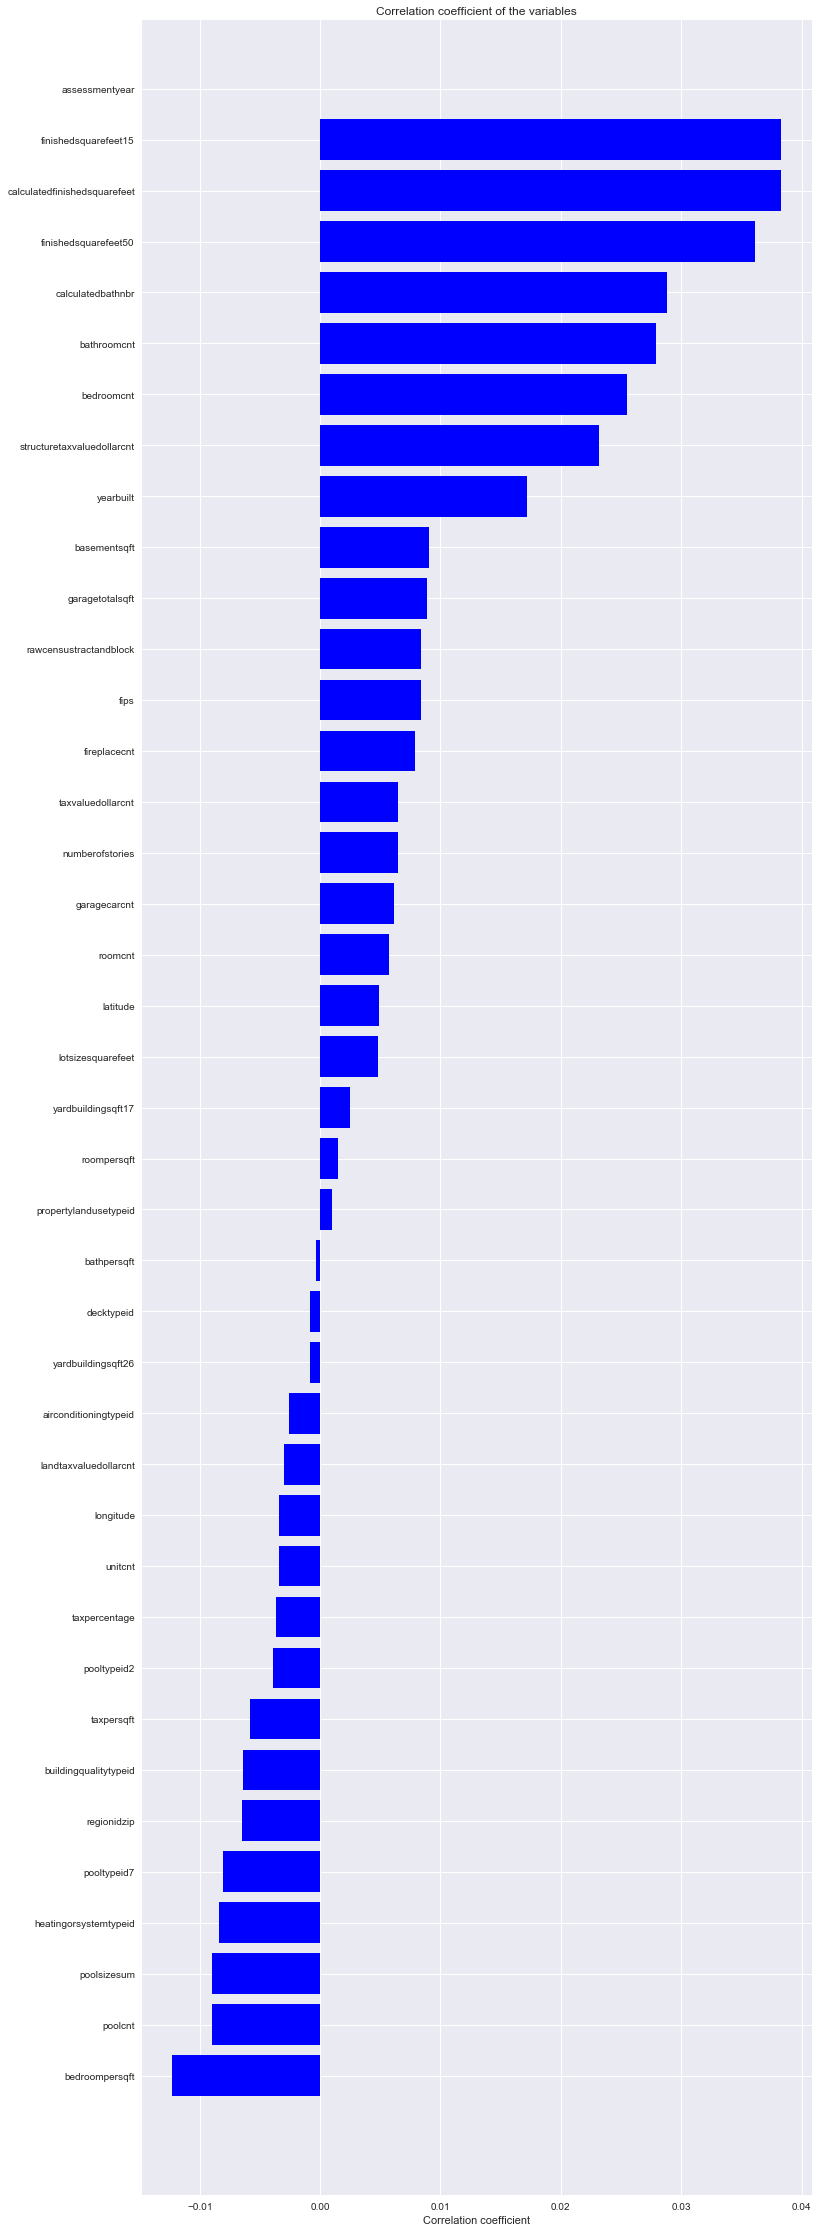

In [82]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in merged_data.columns if col not in ['logerror'] if merged_data[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(merged_data[col].values, merged_data.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

There is not an apparent strong correlation between any of the features and the target variable.

Let's analyze the variables with a greater level of correlation.

In [83]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
39,bedroompersqft,-0.012276
31,structuretaxvaluedollarcnt,0.023141
3,bedroomcnt,0.025467
2,bathroomcnt,0.027889
5,calculatedbathnbr,0.028788
9,finishedsquarefeet50,0.036174
7,calculatedfinishedsquarefeet,0.038305
8,finishedsquarefeet15,0.038305


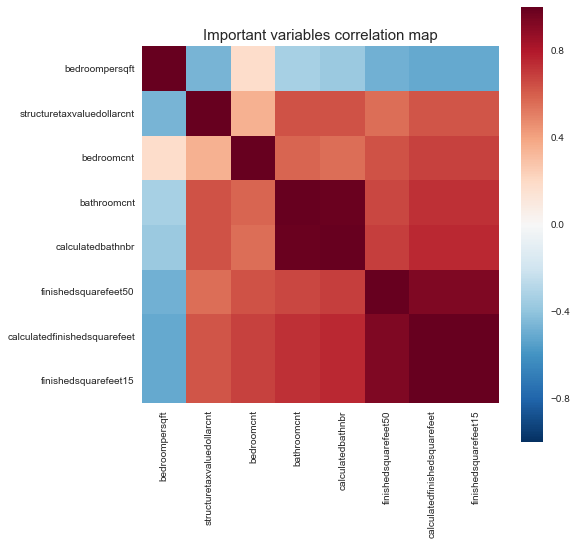

In [84]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = merged_data[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

There is a high correlation between the important variables! That's a good sign.

### Implement LightGBM

In [85]:
import gc

In [86]:
#print('Loading data ...')

#train = pd.read_csv('../input/train_2016.csv')
#prop = pd.read_csv('../input/properties_2016.csv')

for c, dtype in zip(merged_data.columns, merged_data.dtypes):	
    if dtype == np.float64 or dtype == np.int64:		
        merged_data[c] = merged_data[c].astype(np.float32)

#df_train = train_data.merge(property_data, how='left', on='parcelid')
df_train = merged_data
df_train.head(10)

,parcelid,logerror,transactiondate,sale_month,sale_day,sale_year,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet15,finishedsquarefeet50,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidzip,roomcnt,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxdelinquencyflag,taxpercentage,taxpersqft,bathpersqft,roompersqft,bedroompersqft
0,11016594.0,0.0276,2016-01-01,1.0,1.0,2016.0,1.0,0.0,2.0,3.0,4.0,2.0,0.0,1684.0,1684.0,1684.000000,6037.0,0.0,0.0,0.0,0.0,2.0,34280992.0,-118488536.0,7528.000000,0.0,0.0,0.0,0.0,0100,261.0,LARS,60371068.0,96370.0,0.0,1.0,0.0,0.0,1959.0,1.0,0.0,122754.0,360170.0,2015.0,237416.0,0.0,0.018702,213.877670,0.001188,0.000000,0.001781
1,14366692.0,-0.1684,2016-01-01,1.0,1.0,2016.0,5.0,0.0,3.5,4.0,7.0,3.5,0.0,2263.0,2263.0,2263.000000,6059.0,0.0,2.0,468.0,0.0,13.0,33668120.0,-117677552.0,3643.000000,0.0,0.0,0.0,0.0,1,261.0,LAR1,60590524.0,96962.0,0.0,1.0,0.0,0.0,2014.0,1.0,0.0,346458.0,585529.0,2015.0,239071.0,0.0,0.017340,258.740173,0.001547,0.000000,0.001768
2,12098116.0,-0.0040,2016-01-01,1.0,1.0,2016.0,1.0,0.0,3.0,2.0,4.0,3.0,0.0,2217.0,2217.0,2217.000000,6037.0,0.0,0.0,0.0,0.0,2.0,34136312.0,-118175032.0,11423.000000,0.0,0.0,0.0,0.0,0100,261.0,PSR6,60374640.0,96293.0,0.0,1.0,0.0,0.0,1940.0,1.0,0.0,61994.0,119906.0,2015.0,57912.0,0.0,0.095779,54.084801,0.001353,0.000000,0.000902
3,12643413.0,0.0218,2016-01-02,1.0,2.0,2016.0,1.0,0.0,2.0,2.0,4.0,2.0,0.0,839.0,839.0,839.000000,6037.0,0.0,0.0,0.0,0.0,2.0,33755800.0,-118309000.0,70859.000000,0.0,0.0,0.0,0.0,010C,266.0,LAR3,60372964.0,96222.0,0.0,1.0,0.0,0.0,1987.0,1.0,0.0,171518.0,244880.0,2015.0,73362.0,0.0,0.012450,291.871277,0.002384,0.000000,0.002384
4,14432541.0,-0.0050,2016-01-02,1.0,2.0,2016.0,5.0,0.0,2.5,4.0,7.0,2.5,0.0,2283.0,2283.0,1767.299316,6059.0,0.0,2.0,598.0,0.0,13.0,33485644.0,-117700232.0,6000.000000,1.0,495.0,0.0,1.0,122,261.0,LAR1,60590424.0,96961.0,8.0,1.0,0.0,0.0,1981.0,2.0,0.0,169574.0,434551.0,2015.0,264977.0,0.0,0.012631,190.342087,0.001095,0.003504,0.001752
5,11509835.0,-0.2705,2016-01-02,1.0,2.0,2016.0,1.0,0.0,4.0,4.0,1.0,4.0,0.0,3067.0,3067.0,3067.000000,6037.0,0.0,0.0,0.0,0.0,2.0,33870088.0,-118402768.0,2708.000000,0.0,0.0,0.0,0.0,0100,261.0,HBR3YY,60376212.0,96109.0,0.0,1.0,0.0,0.0,1982.0,1.0,0.0,880650.0,2447951.0,2015.0,1567301.0,0.0,0.011081,798.158142,0.001304,0.000000,0.001304
6,12286022.0,0.0440,2016-01-02,1.0,2.0,2016.0,5.0,0.0,1.0,2.0,7.0,1.0,0.0,1297.0,1297.0,1297.000000,6037.0,0.0,0.0,0.0,0.0,7.0,33899476.0,-118212720.0,6677.000000,0.0,0.0,0.0,0.0,0100,261.0,CORH*,60375416.0,96091.0,0.0,1.0,0.0,0.0,1939.0,1.0,0.0,64549.0,111521.0,2015.0,46972.0,0.0,0.020668,85.983810,0.000771,0.000000,0.001542
7,17177300.0,0.1638,2016-01-02,1.0,2.0,2016.0,5.0,0.0,2.5,3.0,7.0,2.5,0.0,1763.0,1763.0,853.000000,6111.0,1.0,2.0,0.0,0.0,13.0,34207204.0,-119165592.0,22822.804688,0.0,0.0,0.0,0.0,1129,266.0,LAR1,61110032.0,97101.0,6.0,1.0,0.0,0.0,1994.0,2.0,1.0,107000.0,306000.0,2015.0,199000.0,0.0,0.012240,173.567780,0.001418,0.003403,0.001702
8,14739064.0,-0.0030,2016-01-02,1.0,2.0,2016.0,5.0,0.0,1.0,2.0,7.0,1.0,0.0,796.0,796.0,796.000000,6059.0,0.0,1.0,0.0,0.0,13.0,33549600.0,-117678000.0,22822.804688,0.0,0.0,0.0,0.0,34,266.0,LAR1,60590424.0,96987.0,0.0,1.0,0.0,0.0,1984.0,1.0,0.0,66834.0,210064.0,2015.0,143230.0,0.0,0.010344,263.899506,0.001256,0.000000,0.002513
9,14677559.0,0.0843,2016-01-03,1.0,3.0,2016.0,5.0,0.0,2.0,2.0,7.0,2.0,0.0,1260.0,1260.0,1260.000000,6059.0,0.0,1.0,0.0,0.0,13.0,33612700.0,-117742000.0,22822.804688,0.0,0.0,0.0,0.0,34,266.0,LAR1,60590628.0,96963.0,5.0,1.0,0.0,0.0,1977.0,1.0,0.0,109977.0,19

In [87]:
merged_data.drop(['sale_month','sale_year','sale_day'],axis=1,inplace=True)

In [88]:
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

((90275, 43), (90275,))


In [89]:
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

split = 90000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train = x_train.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

'''
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.345    # feature_fraction (small values => use very different submodels)
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3
'''

"\nparams = {}\nparams['max_bin'] = 10\nparams['learning_rate'] = 0.0021 # shrinkage_rate\nparams['boosting_type'] = 'gbdt'\nparams['objective'] = 'regression'\nparams['metric'] = 'l1'          # or 'mae'\nparams['sub_feature'] = 0.345    # feature_fraction (small values => use very different submodels)\nparams['bagging_fraction'] = 0.85 # sub_row\nparams['bagging_freq'] = 40\nparams['num_leaves'] = 512        # num_leaf\nparams['min_data'] = 500         # min_data_in_leaf\nparams['min_hessian'] = 0.05     # min_sum_hessian_in_leaf\nparams['verbose'] = 0\nparams['feature_fraction_seed'] = 2\nparams['bagging_seed'] = 3\n"

In [90]:
watchlist = [d_valid]
clf = lgb.train(params, d_train, 500, watchlist)

del d_train, d_valid; gc.collect()
del x_train, x_valid; gc.collect()

print("Prepare for the prediction ...")
sample = pd.read_csv('sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(property_data, on='parcelid', how='left')
del sample; gc.collect()
x_test = df_test[train_columns]
del df_test; gc.collect()
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
x_test = x_test.values.astype(np.float32, copy=False)

print("Start prediction ...")
# num_threads > 1 will predict very slow in kernal
clf.reset_parameter({"num_threads":1})
p_test = clf.predict(x_test)

del x_test; gc.collect()

print("Start write result ...")
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('lgb_results.csv', index=False, float_format='%.4f')

[1]	valid_0's l1: 0.0721204
[2]	valid_0's l1: 0.0721218
[3]	valid_0's l1: 0.0721179
[4]	valid_0's l1: 0.0721126
[5]	valid_0's l1: 0.072111
[6]	valid_0's l1: 0.0721128
[7]	valid_0's l1: 0.0721112
[8]	valid_0's l1: 0.0721103
[9]	valid_0's l1: 0.0721109
[10]	valid_0's l1: 0.0721128
[11]	valid_0's l1: 0.0721044
[12]	valid_0's l1: 0.0721003
[13]	valid_0's l1: 0.0720987
[14]	valid_0's l1: 0.0720975
[15]	valid_0's l1: 0.072095
[16]	valid_0's l1: 0.0720909
[17]	valid_0's l1: 0.0720896
[18]	valid_0's l1: 0.0720871
[19]	valid_0's l1: 0.072087
[20]	valid_0's l1: 0.072085
[21]	valid_0's l1: 0.0720806
[22]	valid_0's l1: 0.0720737
[23]	valid_0's l1: 0.0720746
[24]	valid_0's l1: 0.0720729
[25]	valid_0's l1: 0.072074
[26]	valid_0's l1: 0.0720753
[27]	valid_0's l1: 0.0720704
[28]	valid_0's l1: 0.0720674
[29]	valid_0's l1: 0.0720663
[30]	valid_0's l1: 0.0720617
[31]	valid_0's l1: 0.0720623
[32]	valid_0's l1: 0.0720579
[33]	valid_0's l1: 0.0720536
[34]	valid_0's l1: 0.0720484
[35]	valid_0's l1: 0.0720442

[283]	valid_0's l1: 0.0717384
[284]	valid_0's l1: 0.0717405
[285]	valid_0's l1: 0.0717425
[286]	valid_0's l1: 0.0717411
[287]	valid_0's l1: 0.0717439
[288]	valid_0's l1: 0.0717425
[289]	valid_0's l1: 0.0717421
[290]	valid_0's l1: 0.071744
[291]	valid_0's l1: 0.0717464
[292]	valid_0's l1: 0.0717435
[293]	valid_0's l1: 0.0717445
[294]	valid_0's l1: 0.0717452
[295]	valid_0's l1: 0.071744
[296]	valid_0's l1: 0.0717462
[297]	valid_0's l1: 0.0717466
[298]	valid_0's l1: 0.0717441
[299]	valid_0's l1: 0.0717449
[300]	valid_0's l1: 0.0717427
[301]	valid_0's l1: 0.0717426
[302]	valid_0's l1: 0.0717433
[303]	valid_0's l1: 0.0717433
[304]	valid_0's l1: 0.0717432
[305]	valid_0's l1: 0.0717438
[306]	valid_0's l1: 0.0717431
[307]	valid_0's l1: 0.0717459
[308]	valid_0's l1: 0.0717474
[309]	valid_0's l1: 0.0717503
[310]	valid_0's l1: 0.071747
[311]	valid_0's l1: 0.0717473
[312]	valid_0's l1: 0.0717476
[313]	valid_0's l1: 0.0717447
[314]	valid_0's l1: 0.0717447
[315]	valid_0's l1: 0.071747
[316]	valid_0'